# [](http://)[](http://)# Dogs vs Cats — CNN Image Classification

## Projenin Açıklaması

Bu proje, **Convolutional Neural Network (CNN)** kullanarak kedi ve köpek resimlerini sınıflandırmayı amaçlayan bir derin öğrenme çalışmasıdır.
Projenin temel hedefleri şunlardır:

1. **Veri ön işleme ve görselleştirme**
    * Eğitim, doğrulama ve test setlerine ayırma
    * Örnek görsellerin gösterilmesi
    * Data augmentation (yatay çevirme, döndürme, zoom) ile veri çeşitliliğinin artırılması

2. **CNN modeli oluşturma ve eğitme**
   * Convolutional ve pooling katmanları ile özellik çıkarımı
   * Dense katmanlar ile sınıflandırma
   * Dropout ve L2 regularization ile overfitting’in önlenmesi

3. **Model değerlendirme ve analiz**
   * Accuracy ve loss grafikleri ile eğitim sürecinin izlenmesi
   * Confusion matrix ve classification report ile sınıf bazlı performansın incelenmesi
   * ROC ve AUC grafikleri ile modelin sınıflandırma gücünün ölçülmesi
   * Grad-CAM ile modelin tahminlerde hangi bölgeleri dikkate aldığının görselleştirilmesi

4. **Hiperparametre optimizasyonu**
    * Keras Tuner ile filtre sayısı, katman sayısı, dropout oranı, dense boyutu ve learning rate’in optimize edilmesi

Projenin genel amacı, **derin öğrenme** ve **CNN mimarisinin temel işleyişini anlamak**, **model performansını artıracak yöntemleri uygulamak** ve **sınıflandırma sonuçlarını yorumlayabilmektir**.

## 1) Kütüphanelerin İçe Aktarılması

Bu bölümde proje boyunca kullanacağımız temel Python kütüphanelerini yüklüyoruz.  
- `os, glob, pathlib` → dosya işlemleri  
- `numpy, random` → matematiksel hesaplamalar  
- `matplotlib` → görselleştirme  
- `scikit-learn` → train/validation/test ayırma ve metrikler  
- `tensorflow / keras` → CNN modelini kurmak ve eğitmek için derin öğrenme framework’ü


In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## 2) Dataset’in Yüklenmesi ve Ayrılması

`image_dataset_from_directory` fonksiyonunu kullanarak veriyi klasör yapısından direkt okuyoruz.  
- **Train** → Modelin öğrenmesi için  
- **Validation** → Eğitim sırasında doğrulama için  
- **Test** → Modelin final başarısını görmek için  

Ayrıca resimler **128x128 piksel** boyutuna dönüştürülüyor ve **32 batch size** kullanılıyor.

In [9]:
DATA_DIR = '/kaggle/input/dogs-vs-cats/dataset'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32


train_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'validation'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


test_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 12461 files belonging to 2 classes.


## 3) Dataset’ten Örnek Görseller

Her sınıftan rastgele birkaç görsel seçip görselleştiriyoruz.  
Bu sayede veri kümesinin içeriği gözlemleniyor ve modelin hangi tür görsellerle çalışacağı görülüyor.

Bulunan sınıflar: ['dogs', 'cats']


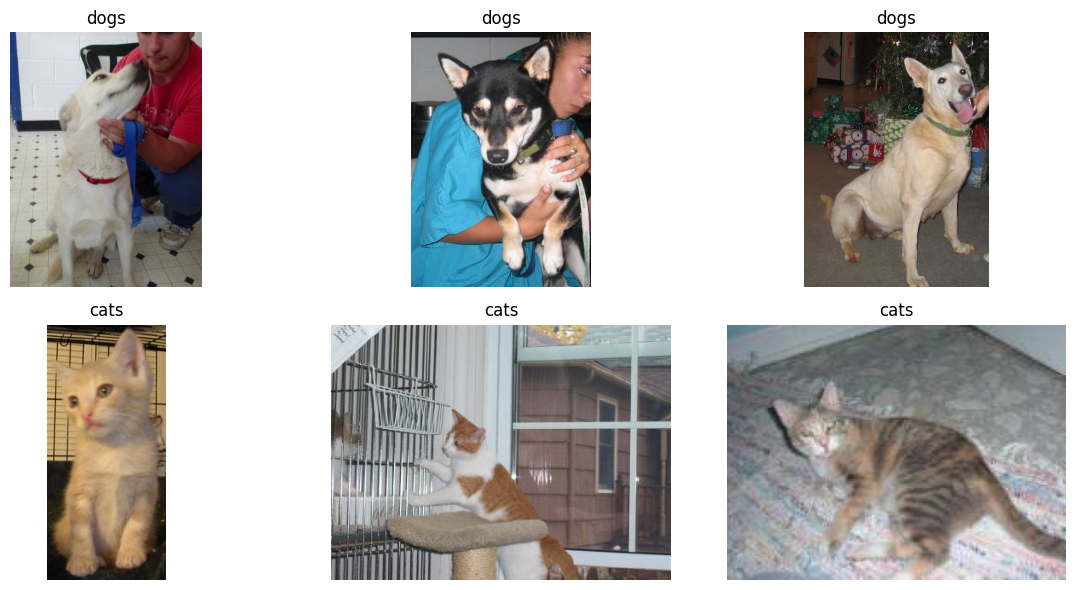

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Base directory (train dataset)
base_dir = "/kaggle/input/dogs-vs-cats/dataset/train"

# Klasör isimlerini otomatik al
class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
print("Bulunan sınıflar:", class_dirs)

# Her sınıftan rastgele 3 görsel al
plt.figure(figsize=(12, 6))

for i, class_name in enumerate(class_dirs):
    class_dir = os.path.join(base_dir, class_name)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    random_imgs = random.sample(images, 3)

    for j, img_name in enumerate(random_imgs):
        img_path = os.path.join(class_dir, img_name)
        try:
            img = mpimg.imread(img_path)
            ax = plt.subplot(len(class_dirs), 3, i*3 + j + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")
        except Exception as e:
            print(f"Hatalı resim atlandı: {img_path} ({e})")

plt.tight_layout()
plt.show()

## 4) Data Augmentation

Veri artırma, modelin genelleme gücünü artırmak için kullanılır.  
Burada uyguladığımız dönüşümler:
- Yatay çevirme (`RandomFlip`)  
- Döndürme (`RandomRotation`)  
- Yakınlaştırma (`RandomZoom`)  

Bu sayede model farklı açılardan/kırpılmış resimlerle karşılaşıp daha dayanıklı hale gelir.


In [13]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
])


train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

## 5) CNN Modelinin Tanımlanması

Burada `build_cnn_model` fonksiyonu ile CNN mimarisini kuruyoruz.  
Kullanılan katmanlar:  
- **Conv2D + BatchNorm** → Görsel özelliklerin öğrenilmesi  
- **MaxPooling** → Boyut azaltma  
- **Dropout + L2 regularization** → Overfitting’i engelleme  
- **Dense katman** → Öğrenilen özelliklerin sınıflandırılması  
- **Softmax çıkış** → 2 sınıf (kedi vs köpek) tahmini

In [14]:
NUM_CLASSES = 2
HP = {
    'num_conv_blocks': 3,
    'initial_filters': 32,
    'kernel_size': 3,
    'dropout_rate': 0.4,
    'dense_units': 256,
    'learning_rate': 1e-3,
    'optimizer': 'adam'
}


def build_cnn_model(img_size=IMG_SIZE, hp=HP, l2_reg=1e-4):
    inputs = keras.Input(shape=(*img_size, 3))
    x = inputs
    filters = hp['initial_filters']
    for i in range(hp['num_conv_blocks']):
        x = layers.Conv2D(filters, (hp['kernel_size'], hp['kernel_size']), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (hp['kernel_size'], hp['kernel_size']), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2,2))(x)
        if hp['dropout_rate'] > 0:
            x = layers.Dropout(hp['dropout_rate'])(x)
        filters *= 2
        
    x = layers.Flatten()(x)
    x = layers.Dense(hp['dense_units'], activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(hp['dropout_rate'])(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    
    if hp['optimizer'] == 'adam':
        opt = keras.optimizers.Adam(learning_rate=hp['learning_rate'])
    elif hp['optimizer'] == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=hp['learning_rate'], momentum=0.9)
    else:
        opt = keras.optimizers.Adam(learning_rate=hp['learning_rate'])
    
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_model()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             

 Total params: 8,678,178 (33.10 MB)

 Trainable params: 8,677,282 (33.10 MB)

 Non-trainable params: 896 (3.50 KB)

## 6) Callback Fonksiyonları

Callback’ler eğitim sürecini kontrol eder:  
- **EarlyStopping** → Validation loss uzun süre iyileşmezse eğitimi durdurur.  
- **ModelCheckpoint** → En iyi modeli kaydeder.  
- **ReduceLROnPlateau** → Öğrenme oranını dinamik olarak küçültür.  
- **TensorBoard** → Eğitim sürecini görselleştirmeye yarar.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard


logdir = './logs'
early = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
ckpt = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
tensorboard_cb = TensorBoard(log_dir=logdir)
callbacks = [early, ckpt, reduce_lr, tensorboard_cb]

## 7) Modelin Eğitilmesi

Modeli 25 epoch boyunca eğitiyoruz. Callback’ler sayesinde model gereksiz yere fazla epoch çalışmaz ve en iyi ağırlıkları kaydeder.

In [17]:
EPOCHS = 25
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/25


I0000 00:00:1758729266.430357     108 service.cc:148] XLA service 0x7c12c4002350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758729266.431111     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758729267.651772     108 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758729276.868474     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 207ms/step - accuracy: 0.5262 - loss: 2.3413 - val_accuracy: 0.5182 - val_loss: 1.7267 - learning_rate: 0.0010
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 115s 182ms/step - accuracy: 0.5484 - loss: 0.7776 - val_accuracy: 0.5168 - val_loss: 1.2229 - learning_rate: 0.0010
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 180ms/step - accuracy: 0.5067 - loss: 0.7833 - val_accuracy: 0.5152 - val_loss: 0.8192 - learning_rate: 0.0010
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 181ms/step - accuracy: 0.4962 - loss: 0.7756 - val_accuracy: 0.5090 - val_loss: 0.7850 - learning_rate: 0.0010
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 179ms/step - accuracy: 0.4982 - loss: 0.7546 - val_accuracy: 0.5028 - val_loss: 0.7864 - learning_rate: 0.0010
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 177ms/step - accuracy: 0.4971 - loss: 0.7395 - val_accuracy: 0.4984 - val_loss: 0.7354 - learning_rate: 0.0010
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 111s 175ms/step - accuracy: 0.4985 

## 8) Eğitim Sonuçlarının Görselleştirilmesi

Accuracy (doğruluk) ve Loss (kayıp) değerlerini hem train hem validation için çiziyoruz.  
- **Eğer train accuracy >> val accuracy** → Overfitting  
- **Eğer train ve val düşük ama yakın** → Underfitting  
- **Eğer her ikisi yüksek ve birbirine yakın** → Başarılı model


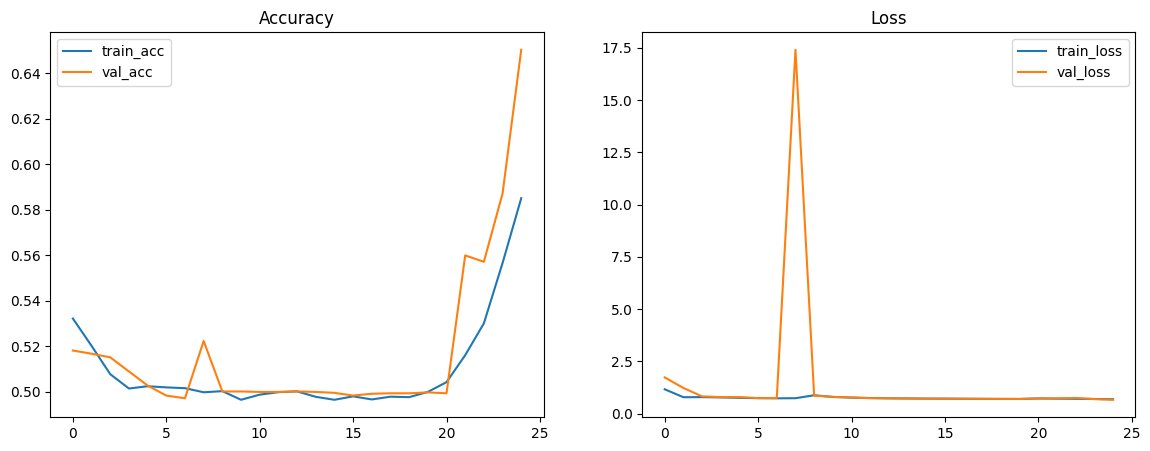

In [18]:
def plot_history(history):
    fig, ax = plt.subplots(1,2, figsize=(14,5))
    ax[0].plot(history.history['accuracy'], label='train_acc')
    ax[0].plot(history.history['val_accuracy'], label='val_acc')
    ax[0].set_title('Accuracy')
    ax[0].legend()
    
    ax[1].plot(history.history['loss'], label='train_loss')
    ax[1].plot(history.history['val_loss'], label='val_loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_history(history)

## 9) Test Seti Değerlendirme ve Confusion Matrix

Test verisi üzerinde modeli değerlendiriyoruz:  
- **Classification Report** → Precision, Recall, F1 skorları  
- **Confusion Matrix** → Modelin hangi sınıfları doğru/yanlış tahmin ettiğini görselleştirir


390/390 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step
              precision    recall  f1-score   support

         cat       0.65      0.65      0.65      6242
         dog       0.65      0.65      0.65      6219

    accuracy                           0.65     12461
   macro avg       0.65      0.65      0.65     12461
weighted avg       0.65      0.65      0.65     12461



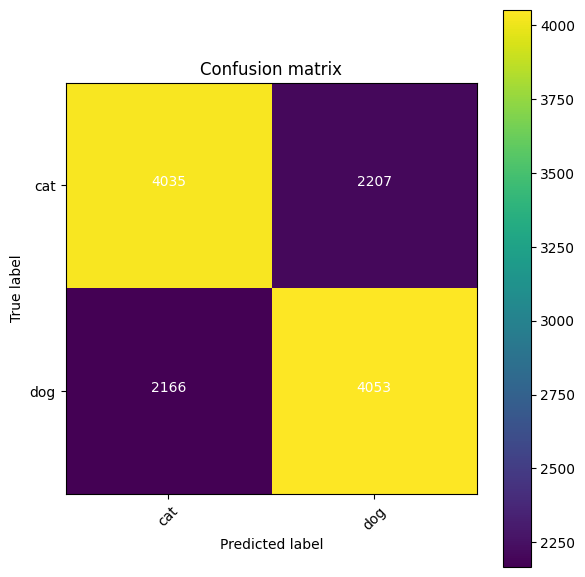

In [20]:
# Bu versiyon batch-by-batch döngü yerine model.predict ile tüm test setini tek seferde tahmin eder.

from sklearn.metrics import classification_report, confusion_matrix

# Tüm test seti için tahmin
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Tüm true label’lar
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Classification report
print(classification_report(y_true, y_pred, target_names=['cat','dog']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=['cat','dog'])

## 10) Grad-CAM Görselleştirmesi

Grad-CAM yöntemi ile modelin tahmin yaparken resmin hangi bölgelerine dikkat ettiğini inceliyoruz.  
Bu, CNN’lerin karar mekanizmasını açıklamak için kullanılan popüler bir yöntemdir.  
Örn: Köpek resimlerinde yüz bölgesine yoğunlaşması beklenir.


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_20']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


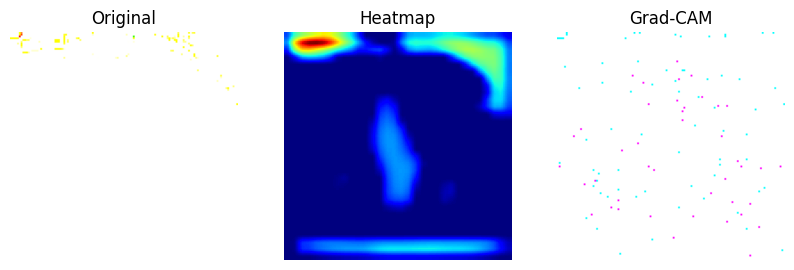

In [21]:
import cv2
import tensorflow.keras.backend as K


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

last_conv_layer_name = [layer.name for layer in reversed(model.layers) if isinstance(layer, layers.Conv2D)][0]

sample_img, _ = next(iter(test_ds))
img_array = tf.expand_dims(sample_img[0], axis=0)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)


img_orig = cv2.resize(sample_img[0].numpy(), IMG_SIZE)
heatmap = cv2.resize(heatmap, (img_orig.shape[1], img_orig.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap_color * 0.4 + np.uint8(img_orig*255)


plt.figure(figsize=(10,5))
plt.subplot(1,3,1); plt.title('Original'); plt.imshow(img_orig); plt.axis('off')
plt.subplot(1,3,2); plt.title('Heatmap'); plt.imshow(heatmap, cmap='jet'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Grad-CAM'); plt.imshow(superimposed_img[:,:,::-1]); plt.axis('off')
plt.show()

## 11-14) Keras Tuner ile Hiperparametre Optimizasyonu

Burada `Keras Tuner` kullanarak modelin farklı parametrelerini otomatik deniyoruz:  
- Conv blok sayısı  
- Filtre sayısı  
- Dropout oranı  
- Dense katman boyutu  
- Learning rate  

Sonuçta en iyi hiperparametreler seçilerek modelin performansı artırılır.


In [33]:
#cell 11
import keras_tuner as kt

def build_model_for_tuning(hp):
    inputs = keras.Input(shape=(*IMG_SIZE,3))
    x = inputs
    filters = hp.Int('initial_filters', min_value=16, max_value=64, step=16)
    num_conv_blocks = hp.Int('num_conv_blocks', 2, 4)
    dropout_rate = hp.Float('dropout_rate', 0.2, 0.5, step=0.1)
    dense_units = hp.Int('dense_units', 128, 512, step=128)
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    
    for i in range(num_conv_blocks):
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
        x = layers.BatchNormalization()(x) 
        x = layers.MaxPooling2D((2,2))(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
        filters *= 2
        
    x = layers.Flatten()(x)
    x = layers.Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [26]:
#cell 12

tuner = kt.RandomSearch(
    build_model_for_tuning,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_tuner',
    project_name='dogs_vs_cats'
)

## 13) En İyi Modeli Getirme ve Özet

In [28]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │    12,583,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           770 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,138,882 (53.94 MB)

 Trainable params: 14,136,962 (53.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

## 14) En İyi Hiperparametreleri Görüntüleme

In [29]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("En iyi hiperparametreler:")
print(f"initial_filters: {best_hps.get('initial_filters')}")
print(f"num_conv_blocks: {best_hps.get('num_conv_blocks')}")
print(f"dropout_rate: {best_hps.get('dropout_rate')}")
print(f"dense_units: {best_hps.get('dense_units')}")
print(f"learning_rate: {best_hps.get('learning_rate')}")

En iyi hiperparametreler:
initial_filters: 64
num_conv_blocks: 4
dropout_rate: 0.2
dense_units: 384
learning_rate: 0.01


## 15) ROC ve AUC Grafiği

ROC eğrisi, modelin sınıflandırma başarısını farklı eşik değerleri için gösterir.  
- **AUC** değeri ne kadar 1’e yakınsa model o kadar iyidir.


390/390 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step


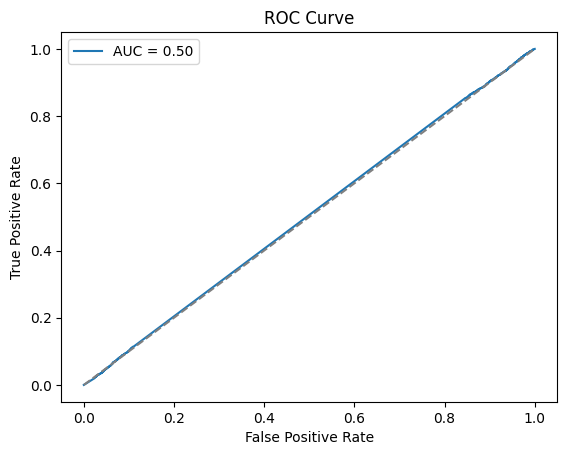

In [35]:
from sklearn.metrics import roc_curve, auc

y_score = best_model.predict(test_ds)[:,1] # dog class için
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], '--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## 16) Precision / Recall / F1 Skorları

Her sınıf için ayrı ayrı Precision, Recall ve F1 skorlarını görselleştiriyoruz.  
Bu, modelin iki sınıfta da dengeli çalışıp çalışmadığını anlamamızı sağlar.


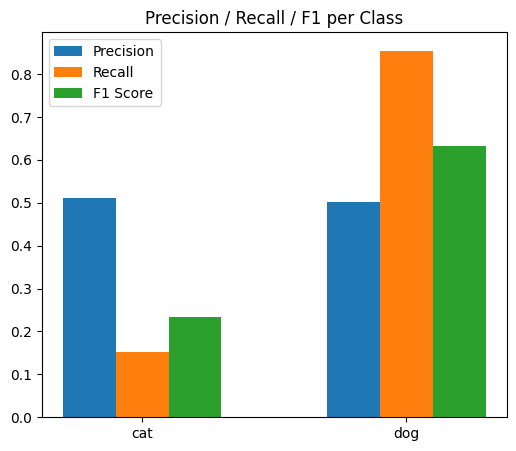

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score


precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)


import numpy as np
x = np.arange(len(precision))
width = 0.2


plt.figure(figsize=(6,5))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1 Score')
plt.xticks(x, ['cat','dog'])
plt.title('Precision / Recall / F1 per Class')
plt.legend()
plt.show()

## 17) Modelin Kaydedilmesi

Elde edilen en iyi model `.h5` formatında kaydedilir.  
Böylece yeniden eğitime gerek kalmadan başka ortamlarda tahmin yapmak için kullanılabilir.


In [38]:
MODEL_PATH = '/kaggle/working/dogs_vs_cats_best_model.h5'
best_model.save(MODEL_PATH)
print(f"Model kaydedildi: {MODEL_PATH}")

Model kaydedildi: /kaggle/working/dogs_vs_cats_best_model.h5
